# Animated COVID-19 Count Infection Rate Visualization

## Welcome!

So you might have just stumbled upon this page, or you might also have just come here from [something you might have seen on Reddit](https://www.reddit.com/r/dataisbeautiful/comments/ho7v6w/oc_covid19_rate_of_spread_map/). Either way you made it, welcome! Glad to have you here. 

## What is this?

This is a county choropleth map that tracks the spread of COVID-19, and highlights the hotspots where the infection rate is high. Some of the ideas of the visual come from [this Reddit post](https://www.reddit.com/r/dataisbeautiful/comments/hl20sz/watch_covid19_spread_throughout_the_continental), but I wanted to see how I could do it without using blender and some of the other tools that were used to accomplish that particular visualization, which is kind of amazingly wonderful. 

## What's the gist of the code?

So here's how it generally works:

1. Get the data from [github](https://github.com/CSSEGISandData/COVID-19). 
1. Format the data. 
1. Interpolate the data to a particular time period for animation smoothness. 
1. Roll through each time period and do the following:
    1. Using Plotly, create and output a county choropleth map for each day, using the Albers projection. 
    1. Create a legend. 
    1. Create a calendar image for that day. 
    1. Create a "Total Confirmed" plot (shown on the lower left) for each day. 
    1. Using IPython tools, combine the previous images. 
    1. Save the image to disk. 
1. Next, pipe all of the images into ffmpeg to create an mp4 video file that contains all the data points. 

### Notes on the data

Some of the data is bad. In some counties, the cumulative confirmed values decrease, as they do for Brazoria County in mid-June. In order to fix this issue, I remove any values that are lower than the cumulative maximum for the time series, and then I interpolate their values instead. This may not give "perfect" data, but in the absence of a subject matter expert who can tell me why these variations exist, I feel it's the fairest thing to do. 

Next, I do a day-by-day diff on the data to get the new cases for each day. This is the core of the information I'm going to chart off of. 

### Notes on FFMpeg. 

So when I started this whole thing, I was originally using Standard GIFs, but the file size was prohibitive, and I was ending up with 40 or 50 meg gif files. A user on Reddit, Samuel Hinton, had already commented on a couple of things that I had done, an we got to talking. Turns out he is kind of an expert in ffmpeg, so he was able to help me sort out some of the issues, and he even [wrote up a blog](https://cosmiccoding.com.au/tutorials/us_covid_evolution) where he explained how to get the glow effect you see in the final project. Special thanks to him, because there was no way I would have figured out how to do that. 

In [321]:
#https://plotly.com/python/reference/

default_title = 'Animated Map - County Spread Rate'

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : '#0d1238'}

import io
import json
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image, clear_output, Video
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from PIL import Image as PILImage
import plotly

plotly.io.orca.config.executable = 'C:\\Users\\izdr\\AppData\\Local\\Programs\\orca\\orca.exe'

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
directory = 'C:\\Users\\izdr\\source\\repos\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\'

!git -C $directory pull

state_names = pd.read_csv('Data/states.csv').set_index('State').to_dict()['Abbreviation']
bgcolor = '#0d1238'

Updating 9458c546..3a1f0e85
Fast-forward
 csse_covid_19_data/README.md                       |    4 +
 .../csse_covid_19_daily_reports/10-25-2020.csv     |   54 +-
 .../csse_covid_19_time_series/Errata.csv           |  136 +-
 .../time_series_covid19_confirmed_US.csv           | 6682 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  536 +-
 .../time_series_covid19_deaths_global.csv          |    4 +-
 .../time_series_covid19_recovered_global.csv       |    2 +-
 7 files changed, 3715 insertions(+), 3703 deletions(-)


From https://github.com/CSSEGISandData/COVID-19
   9458c546..3a1f0e85  master     -> origin/master
   dbc3a03d..aaccbed1  web-data   -> origin/web-data


In [340]:
def get_census_info():
    return (
        pd.read_csv("Data/co-est2019-alldata.csv", encoding = "ISO-8859-1") # Fetch the file
        .query('SUMLEV == 50')                                         # 40 is states, 50 is counties
        [['STATE', 'COUNTY', 'CTYNAME', 'POPESTIMATE2019']]            # Keep Just population estimate
        .assign(fips=lambda x: (x['STATE'] * 1000) + x['COUNTY'])      # FIPS = stateId*1000+countyId                                # 
        .rename(columns={'POPESTIMATE2019':'pop'})                     # Shorten Population Estimate column
        [['fips', 'pop']]                                              # Keep just FIPS and PopEstimate
        .set_index('fips')                                             # Index by FIPS
    )

def get_daily_report_data():
    states = list(state_names.keys())                                 # List of 51 states (including DC)
    return (
        pd.concat([ \
            pd.read_csv(directory+file) \
            .assign(date=datetime.strptime(file, '%m-%d-%Y.csv')) \
            for file \
            in os.listdir(directory) \
            if file.endswith(".csv") \
        ])                                                            # List the files, appending a date column to each file's data
        .reset_index()                                                # Reset the index
        .dropna(subset=['FIPS'])                                      # Pick only items with FIPS values
        .assign(FIPS=lambda x:x['FIPS'].astype(int))                  # And cast that FIPS value to integer
        .query('Province_State.isin(@states)', engine='python')                        # Only the states
    )

def get_county_percentages():
    daily_report_data = get_daily_report_data()
    
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
        .fillna(0)                                                # Fill NA values here.
    )
    
    # Here we're going to ensure cumulative confirmed values are always increasing. 
    # We'll do this by comparing the existing values against the cumulative maximum 
    # for that time series, removing the numbers that don't conform to this, and then 
    # interpolating those missing values. For an example of a time series that does 
    # this, look at the Brazoria County values (48049), between June 8 and 9. The 
    # cumulative maximum drops from 990 to 770, which, since we're creating a differential
    # here, would inject a massive negative value into our rolling average. This clearly
    # isn't the way it's supposed to be, because when you look at the data between
    # June 15 and June 16, the values jump again from 864 to 1495. We'll smooth those
    # values out here, in the absence of any accessible SME who can tell us what 
    # happened, and in the interest of time. 
    daily_report_data = (
        starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
        .interpolate()                       # Interpolate the "actual" values for those items.
        .diff()                              # _Now_ we get our dialy differential. 
        .rolling(window=7)                   # Roll this value 7 days for smoothness. 
        .mean()                              # Take the mean of the rolling window. 
        .dropna()                            # Drop the first 6 rows, an artifact of rolling.
        .T                                   # Transpose the whole DataFrame
    )

    # Grab the county populations
    county_populations = get_census_info()
    
    # Divide the values of new confirmed cases by the county population,
    # and then multiply by 100,000 to get the "per 100,000" people metric.
    return (daily_report_data.div(county_populations.iloc[:,0], axis=0).dropna()) * 100000

def get_allcounties():
    # Get the GEOJson file for the counties.
    with open(os.getcwd() + '/Data/geojson-counties-fips.json') as response:
        allcounties = json.load(response)
    return allcounties

def draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files, timeinterpolation, legend=None, new_cases_info=None):

    if (new_cases_info is None):
        new_cases_info = get_new_cases_info()
        
    clear_output(wait=True)
    date = row.name
    print(date)
    
    foldername = 'gitignore-county-spread-images-{0}'.format(timeinterpolation)
    filename = '{0}/{1:%Y-%m-%d-%H-%M}.png'.format(foldername, date)
    if store_intermediate_files == True:
        if (not os.path.exists(foldername)):
            os.mkdir(foldername)
        if (os.path.exists(filename)):
            return PILImage.open(filename)
    
    if (legend is None):
        legend=get_legend()
        
    calendar = get_calendar(date.year, date.month, date.day)
    new_case_graph = create_new_case_graph(date.year, date.month, date.day, date.hour, timeinterpolation, new_cases_info)
        
    local_directory = os.getcwd()

    row = row[row.index.isin([stateid['id'] for stateid in county_geojson['features']])]

    row = row.reset_index().rename(columns={date:'confirmed'})

    for feature in county_geojson["features"]:
        feature["properties"]["FIPS"] = str(int(feature["properties"]["STATE"])) + feature["properties"]["COUNTY"]

    
    bgcolor = '#0d1238'
    fig = px.choropleth(row, 
                        geojson=county_geojson, 
                        locations='fips', 
                        color='confirmed',
                        color_continuous_scale=colorscale,
                        featureidkey='properties.FIPS',
                        projection='albers usa',
                        title="Where is COVID Spreading?",
                        template='plotly_dark',
                        range_color=[0,zmax],
                        labels={"confirmed": ""}, 
                        width=1920/2,
                        height=1080/2
                      )

    fig.update_geos(
        showcountries=False,
        showcoastlines=True, 
        showframe=False,
        oceancolor=bgcolor,
        lakecolor=bgcolor,
        showland=False, 
        bgcolor=bgcolor)
   
    fig.update_layout(
        plot_bgcolor=bgcolor, 
        paper_bgcolor=bgcolor, 
        title_text = 'COVID-19 Rate of Spread',
        title_xanchor = 'center',
        font=dict(size=36),
        title_x = 0.5,
        title_y = 0.94,
        margin=(dict(
            t=150,
            b=200,
            r=0,
            l=0
        )),
        coloraxis=dict(
            showscale=False,
            colorbar=dict( 
                ticktext=["0","10","20","30", "40","50+"], 
                tickvals=[0,10,20,30,40,50]
            )
        ),
        annotations=[
            dict(
                x=0.02,
                y=-0.23,
                font=dict(
                    color="#A1A1A1",
                    size=20
                ),
                showarrow=False,
                text='Data from Johns Hopkins University COVID-19 DataSet',
                xref="paper",
                yref="paper"
            ),
            dict(
                x=0.5,
                y=1.05,
                yanchor='top',
                xanchor='center',
                font=dict(
                    size=24
                ),
                showarrow=False,
                text='Weekly Rolling Average of New Cases Per 100,000 People',
                xref="paper",
                yref="paper"
            )
        ]
    )
    
    fig.update_traces(marker_line_width=0, showscale=False)
    img_bytes = fig.to_image(format="png", width=1920, height=1080)
    image = PILImage.open(io.BytesIO(img_bytes))
    
    image.paste(legend, (600,920), legend)
    image.paste(calendar, (1500,700), calendar)
    image.paste(new_case_graph, (60,750), new_case_graph)
    
    if store_intermediate_files == True:
        image.save(filename)
    return image

def draw_choropleth_image(row, county_geojson, colorscale, zmax):
    image = draw_choropleth(row, county_geojson, colorscale, zmax)
    url = 'covid19-county-cases.gif'
    image.save(url)
    return url + "?c=" + str(random.randint(0,2e9))

# Starting on 8/31/2020, NY decided to suddenly start reporting for ALL the boroughs separately. Using this code below, 
# I'm going to infer onto dates prior to 8/31 the proper values, by spreading the single county out to multiple counties. 
def distribute_borrough_numbers(starter):
    borroughs = [36081,36047,36005,36085, 36061]
    start_date_for_reporting_all_borrough_values = datetime(2020, 8, 31);
    borrough_values_831 = starter.T.loc[borroughs][start_date_for_reporting_all_borrough_values]
    borrough_weights_831 = borrough_values_831 / borrough_values_831.sum()
    sums_to_830 = starter.T.loc[borroughs].T.query('date < @start_date_for_reporting_all_borrough_values').T.sum()
    distributed_values = pd.DataFrame(np.dot(np.matrix(sums_to_830).T, [borrough_weights_831]), columns=borrough_weights_831.index, index=sums_to_830.index)
    starter.loc[distributed_values.index, distributed_values.columns] = distributed_values
    
def spread_backlog_values(rep_a, startdate, enddate, zipcode, endzip = None):
    if (endzip == None):
        endzip = zipcode
        
    startdate_date = datetime.strptime(startdate, '%Y-%m-%d');
    enddate_date = datetime.strptime(enddate, '%Y-%m-%d');
    delta = enddate_date - startdate_date;
    
    endval = rep_a.loc[enddate, zipcode:endzip];
    rep_a.loc[enddate, zipcode:endzip] = rep_a.loc[startdate:enddate, zipcode:endzip][:-1].mean()
    
    rep_a.loc[startdate:enddate, zipcode:endzip] = rep_a.loc[startdate:enddate, zipcode:endzip] + endval / (delta.days + 1)
    
    
def get_new_cases_info(daily_report_data=None):
    if (daily_report_data is None):
        daily_report_data=get_daily_report_data()
        
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
        .fillna(0)                                                # Fill NA values here.
    )
    
    distribute_borrough_numbers(starter)
    
    spread_backlog_values(starter, '2020-09-09', '2020-09-21',48201) # Harris
    spread_backlog_values(starter, '2020-09-09', '2020-09-21',48013) # Atascosa
    spread_backlog_values(starter, '2020-09-08', '2020-09-20',48029) # Bexar
    spread_backlog_values(starter, '2020-09-10', '2020-09-22',48029) # Bexar
    spread_backlog_values(starter, '2020-09-08', '2020-09-20',48113) # Dallas
    spread_backlog_values(starter, '2020-09-09', '2020-09-21',48163) # Frio
    spread_backlog_values(starter, '2020-09-09', '2020-09-21',48187) # Guadalupe
    spread_backlog_values(starter, '2020-09-09', '2020-09-21',48493) # Wilson
    spread_backlog_values(starter, '2020-09-09', '2020-09-21',48439) # Tarrant
    spread_backlog_values(starter, '2020-09-08', '2020-09-16',1000, 1999)

    rep_a = (
        starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
        .interpolate()                       # Interpolate the "actual" values for those items.
        .rolling(window=7)                   # Roll this value 7 days for smoothness. 
        .mean()                              # Take the mean of the rolling window. 
        .dropna()                            # Drop the first 6 rows, an artifact of rolling.
        .T                                   # Transpose the whole DataFrame
    )

    return (rep_a.sum().diff().dropna())

def create_new_case_graph(year, month, day, hour, timeinterpolation, new_cases_info=None):
    if (new_cases_info is None):
        new_cases_info = get_new_cases_info()
    
    new_cases_info = new_cases_info.resample(rule=timeinterpolation).asfreq().interpolate()
    d = datetime(year,month,day, hour)
    datamax = new_cases_info.max()
    data = new_cases_info.where(lambda x:x.index <= d)

    imgheight = 200
    d3 = pd.DataFrame([a for a in np.linspace(0, 255, 200)**2])

    y = pd.Series(data.values[:-1]).fillna(0)
    y = (y.div(datamax) * imgheight)
    d2 = [np.repeat(0, imgheight - i).tolist() + np.repeat(1, i).tolist() for i in y]
    d2 = pd.DataFrame(d2).T
    d2 = d2[d2==1]
    d2[-1:] = 1
    d4 = d2.mul(d3[0], axis='index')

    x = np.array(list(range(0, len(y))))

    z = np.array(y)
    z_min, z_max = -np.abs(z).max(), np.abs(z).max() 

    current_cmap = plt.cm.get_cmap('inferno_r')
    current_cmap.set_bad(color=bgcolor)

    fig,ax = plt.subplots()
    plt.imshow(d4, cmap=current_cmap, vmin=0, extent=[0,50,0,100], aspect=0.3, interpolation='gaussian')
    ax.xaxis.label.set_text('{0:,.0f} New Cases'.format(data.dropna()[-1]))
    ax.xaxis.label.set_color('white')
    ax.xaxis.label.set_fontsize(40)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_color(bgcolor)
    ax.spines['bottom'].set_color(bgcolor)
    ax.spines['left'].set_color(bgcolor)
    ax.spines['right'].set_color(bgcolor)
    ax.xaxis.set_ticks([])
    for t in ax.xaxis.get_ticklines(): t.set_color(bgcolor)

    iobytes = io.BytesIO()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=60)


    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def draw_single_choropleth(year, month, day):
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    zmax = originalData.max().max()
    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, 'Inferno')))
    row = originalData.loc[datetime(year,month,day)]
    #print(row)
    return draw_choropleth(row, county_geojson, colorscale, zmax, False, timeinterpolation='1D')
    
def make_animation(fps, timeinterpolation, theme, filename, store_intermediate_files):
    
    intermediate_file_location = "gitignore-county-spread-images-{0}".format(timeinterpolation)
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    data = originalData.resample(rule=timeinterpolation).asfreq().interpolate()
    daily_report_data = get_daily_report_data();
    new_cases_info = get_new_cases_info()
    
    
    
    rows = [data.iloc[i] for i in range(0, len(data))]

    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, theme)))
    
    zmax = originalData.max().max()
    legend = get_legend();

    
    images = [draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files, timeinterpolation, legend, new_cases_info) for row in rows]
    #images.extend([images[-1] for i in range(0, repeatlast)])
    
    clear_output()
    
    complex_filter = "\"[1]setsar=sar=0[p],\
[0]split[a][b],\
[a][p]overlay,lumakey=0:tolerance=0.3:softness=0.5[x];\
color=black,format=rgb24[c];\
[c][x]scale2ref[c][i];\
[c][i]overlay=format=auto:shortest=1,\
setsar=sar=1,\
gblur=15:3,\
curves=all='0/0 1/1'[d],\
[b]setsar=sar=1[e],\
[d][e]blend=all_mode=addition,\
scale=1920:-2,\
tpad=stop_mode=clone:stop_duration=3\
\""

    pngfiles = "\"./{0}/*.png\"".format(intermediate_file_location)
    !del files.txt
    !for /f "tokens=*" %G in ('dir /S gitignore-county-spread-images-{timeinterpolation} /b') do echo file '%G' >> files.txt
    print("ffmpeg -r {fps} -f concat -safe 0 -i files.txt -i \"Resources/mask2.png\" -filter_complex {complex_filter} -y -movflags faststart -pix_fmt yuv420p -vsync 0 \"{filename}-{timeinterpolation}.mp4\"".format(fps=fps, pngfiles=pngfiles, complex_filter=complex_filter, filename=filename, timeinterpolation=timeinterpolation))
    !ffmpeg -r {fps} -f concat -safe 0 -i files.txt -i "Resources/mask2.png" -filter_complex {complex_filter} -y -movflags faststart -pix_fmt yuv420p -vsync 0 "{filename}-{timeinterpolation}.mp4"
    return '{0}/{1}.mp4'.format(os.getcwd(), filename)

def get_calendar(year, month, date):
    daysinmonth = (datetime(year, month%12+1,1) - timedelta(days=1)).date().day
    weekdaytostart = datetime(year, month, 1).weekday()
    weekdayfordate = datetime(year, month, date).weekday()
    start_on_sunday = True
    sunday_adjustment = 1 if start_on_sunday else 0
    days_of_week = [[a[0], a[1]] for a in zip(range(1, daysinmonth+1), [(i+sunday_adjustment+weekdaytostart)%7 for i in range(0, daysinmonth)])]
    monthly_calendar_dates = [[None,i] for i in range(0, days_of_week[0][1])] + days_of_week + [[None,i] for i in range(days_of_week[-1][1]+1, 7)]

    calendar_data = pd.DataFrame([[j[0] for j in monthly_calendar_dates[i*7:(i*7)+7]] for i in list(range(0, int(len(monthly_calendar_dates)/7)))])
    week_number = calendar_data[calendar_data == date].idxmax(axis=1).idxmax()
    day_number = calendar_data[calendar_data == date].idxmax(axis=0).idxmax()
    calendar_data_display = pd.DataFrame(calendar_data / calendar_data / 2).fillna(0)

    calendar_data_display.iloc[week_number,day_number] = 1
    title = '{0:%B %Y}'.format(datetime(year,month,date))

    fig, ax = plt.subplots(1, figsize=(2,1.5), dpi=150)

    h = bgcolor.lstrip('#')
    start_color = [tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))][0]+(1,)
    end_color = (1, 1, 1, 1)
    spectrum = [a for a in np.linspace(start_color, end_color, 8)]
    cmap = LinearSegmentedColormap.from_list('Custom', spectrum, len(spectrum))

    annotations = calendar_data.fillna(0).applymap(lambda x:str(int(x))).replace('0', '')
    ax = sns.heatmap(calendar_data_display, linewidths=2, linecolor=bgcolor, cmap=cmap, cbar=False, facecolor=None, ax=ax,
               yticklabels=[], xticklabels=[], annot=annotations, fmt='', annot_kws={"size": 8});

    ax.tick_params(axis='both', which='both', length=0)

    ax.set(
        xlabel='',
        ylabel=''
    )

    ax.set_title(title, color='white')
    iobytes = io.BytesIO()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=200)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def get_legend():
    fig,ax = plt.subplots(figsize=(6,0.15))
    sns.heatmap(pd.DataFrame([[i] for i in range(0, 50)]).T, ax=ax, cbar=False, cmap="inferno");

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([], color='white')
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 10, 20, 30, 40, "50+"], color='white', size=12)
    ax.set(
        xlabel='',
        ylabel=''
    )
    plt.xticks(rotation=0)
    plt.tick_params(labeltop=True, labelbottom=False)
    iobytes = io.BytesIO()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=150)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def update_case_graphs(timeinterpolation):
    new_cases_info = get_new_cases_info()
    dirheader = 'gitignore-county-spread-images-'
    d = '{0}{1}'.format(dirheader, timeinterpolation)
    files = sorted(os.listdir(d))

    for file in files:
        if (file[-4:] == '.png'):
            print(file)
            date = datetime.strptime(file, '%Y-%m-%d-%H-%M.png')
            filename = '{0}/{1}'.format(d, file)
            img = PILImage.open(filename)
            new_case_graph = create_new_case_graph(date.year, date.month, date.day, date.hour, timeinterpolation, new_cases_info)
            img.paste(new_case_graph, (60,750), new_case_graph)
            img.save(filename)
            
def update_map(timeinterpolation):
    !git -C $directory pull
    update_case_graphs(timeinterpolation)
    clear_output()
    url = make_animation(30, timeinterpolation, 'Inferno', default_title, True)
    return url;
    
    

2020-10-26 00:00:00


<ipython-input-318-da007f7bda5f>:290: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno_r"))



       fips  confirmed
0      1001  19.177515
1      1003  20.414197
2      1005  30.092244
3      1007  34.448003
4      1009  25.692842
...     ...        ...
3135  56037  18.218562
3136  56039  27.397594
3137  56041  27.545874
3138  56043  20.133614
3139  56045  50.000000

[3140 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fips       3140 non-null   int64  
 1   confirmed  3140 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.2 KB
None


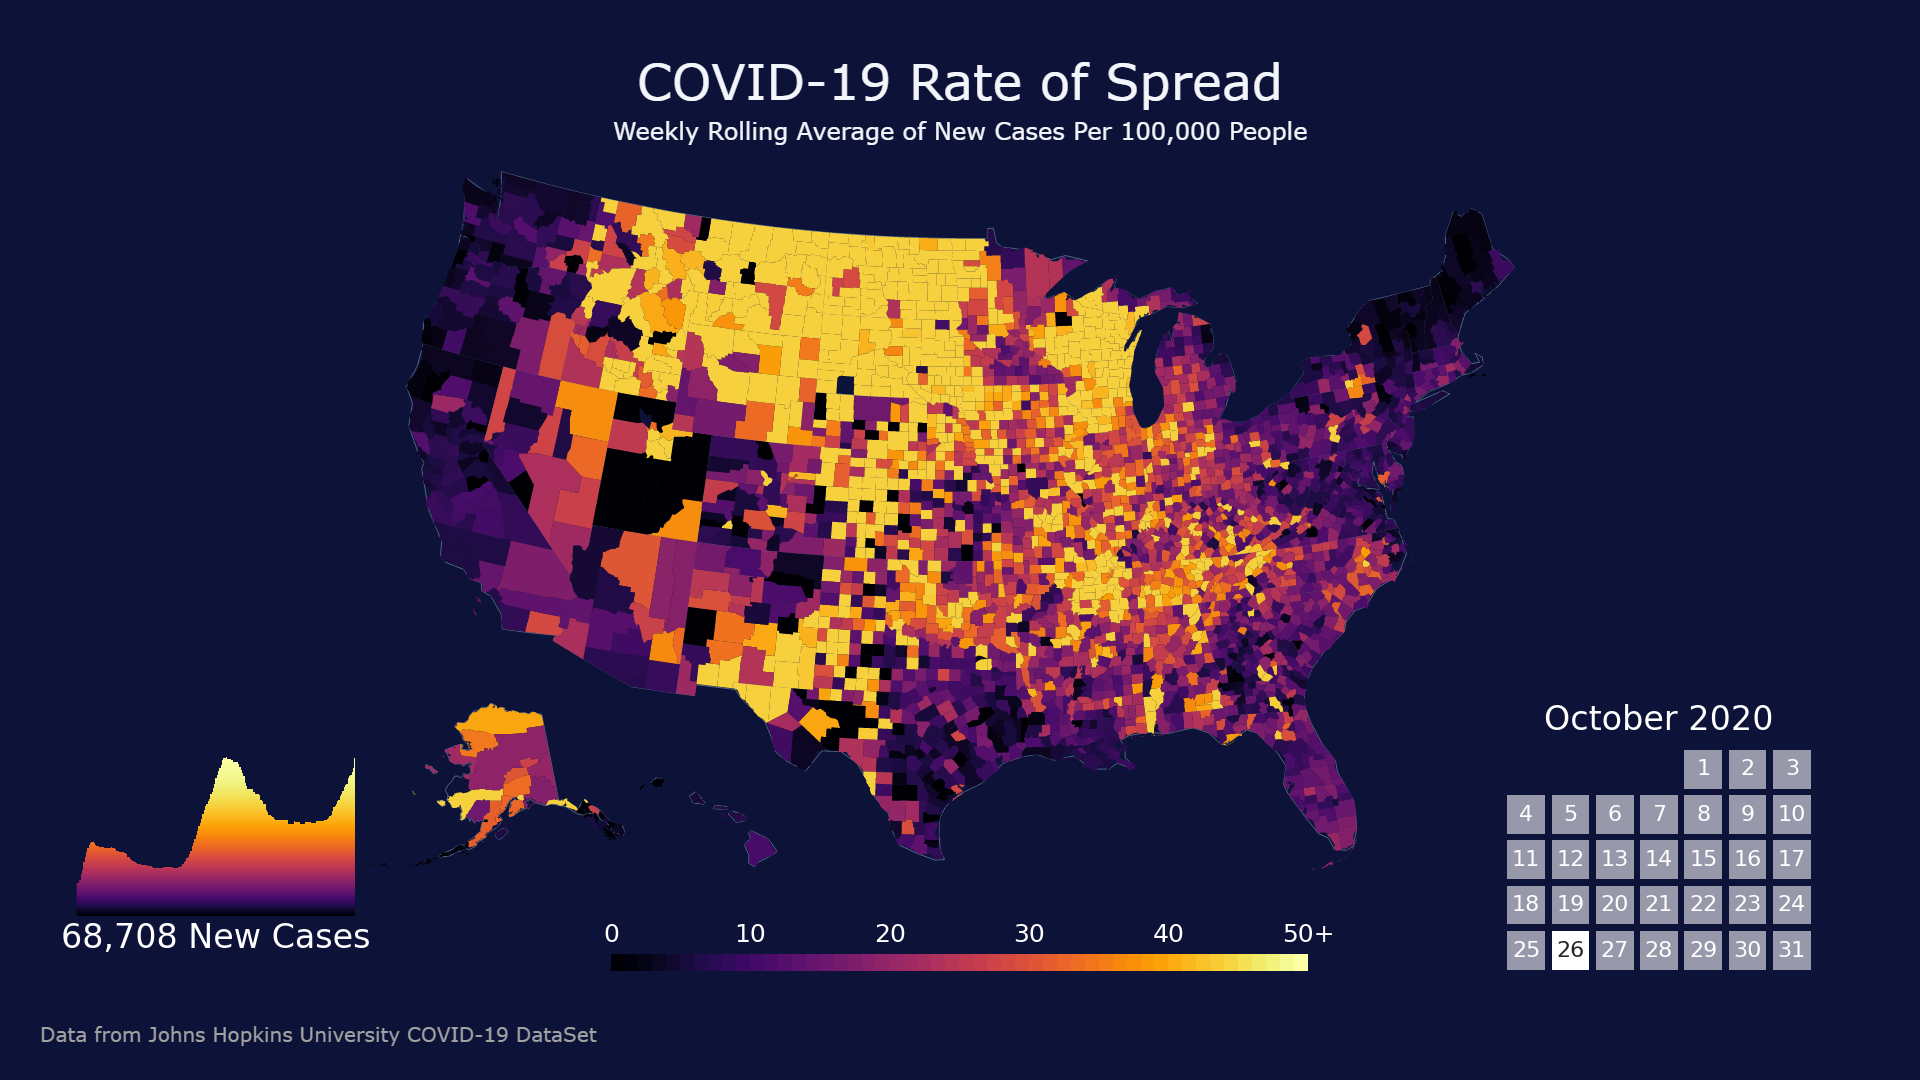

In [319]:
today = datetime.today() - timedelta(1)
background = draw_single_choropleth(today.year, today.month, today.day)
display(background)

In [341]:
url = update_map('15D')
Video(url, embed=True)


Could Not Find C:\Users\izdr\source\repos\COVID-19-Analysis\files.txt



C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-15D\2020-03-29-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-15D\2020-04-13-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-15D\2020-04-28-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-15D\2020-05-13-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-15D\2020-05-28-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-imag

ffmpeg version 4.3.1-2020-10-01-essentials_build-www.gyan.dev Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.0 (Rev3, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm --enable-libopencore-amr

In [342]:
default_title = 'Animated Map - County Spread Rate'
url = make_animation(30, '3D', 'Inferno', default_title, True)
Video(url, embed=True)

ffmpeg -r 30 -f concat -safe 0 -i files.txt -i "Resources/mask2.png" -filter_complex "[1]setsar=sar=0[p],[0]split[a][b],[a][p]overlay,lumakey=0:tolerance=0.3:softness=0.5[x];color=black,format=rgb24[c];[c][x]scale2ref[c][i];[c][i]overlay=format=auto:shortest=1,setsar=sar=1,gblur=15:3,curves=all='0/0 1/1'[d],[b]setsar=sar=1[e],[d][e]blend=all_mode=addition,scale=1920:-2,tpad=stop_mode=clone:stop_duration=3" -y -movflags faststart -pix_fmt yuv420p -vsync 0 "Animated Map - County Spread Rate-3D.mp4"

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-3D\2020-03-29-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-3D\2020-04-01-00-00.png'  1>>files.txt 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-3D\2020-04-04-00-00

ffmpeg version 4.3.1-2020-10-01-essentials_build-www.gyan.dev Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.0 (Rev3, Built by MSYS2 project)


  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libtheora --enable-libvo-amrwbenc --enable-libgsm --enable-libopencore-amrnb --enable-libopus --enable-libspeex --enable-libvorbis --enable-librubberband
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
 

In [149]:
county_percentages = get_county_percentages()
new_cases_info = get_new_cases_info()

<AxesSubplot:xlabel='date'>

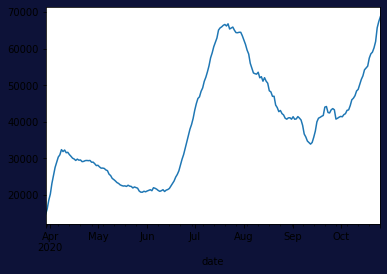

In [151]:

new_cases_info.plot.line()

In [41]:
drd = get_daily_report_data()

<AxesSubplot:xlabel='date'>

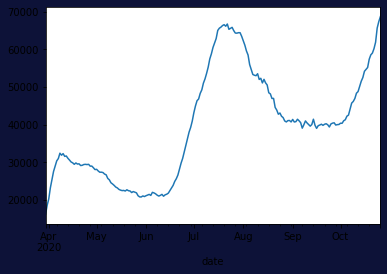

In [317]:


starter = (
    drd
    [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
    .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
    .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
    .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
    .fillna(0)                                                # Fill NA values here.
)

distribute_borrough_numbers(starter)

def spread_backlog_values(rep_a, startdate, enddate, zipcode, endzip = None):
    if (endzip == None):
        endzip = zipcode
        
    startdate_date = datetime.strptime(startdate, '%Y-%m-%d');
    enddate_date = datetime.strptime(enddate, '%Y-%m-%d');
    delta = enddate_date - startdate_date;
    
    endval = rep_a.loc[enddate, zipcode:endzip];
    rep_a.loc[enddate, zipcode:endzip] = rep_a.loc[startdate:enddate, zipcode:endzip][:-1].mean()
    
    rep_a.loc[startdate:enddate, zipcode:endzip] = rep_a.loc[startdate:enddate, zipcode:endzip] + endval / (delta.days + 1)
    
spread_backlog_values(starter, '2020-09-09', '2020-09-21',48201) # Harris
spread_backlog_values(starter, '2020-09-09', '2020-09-21',48013) # Atascosa
spread_backlog_values(starter, '2020-09-08', '2020-09-20',48029) # Bexar
spread_backlog_values(starter, '2020-09-10', '2020-09-22',48029) # Bexar
spread_backlog_values(starter, '2020-09-08', '2020-09-20',48113) # Dallas
spread_backlog_values(starter, '2020-09-09', '2020-09-21',48163) # Frio
spread_backlog_values(starter, '2020-09-09', '2020-09-21',48187) # Guadalupe
spread_backlog_values(starter, '2020-09-09', '2020-09-21',48493) # Wilson
spread_backlog_values(starter, '2020-09-09', '2020-09-21',48439) # Tarrant
spread_backlog_values(starter, '2020-09-08', '2020-09-16',1000, 1999)

rep_a = (
    starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
    .interpolate()                       # Interpolate the "actual" values for those items.
    .diff()
)



# rep_a.loc['2020-09-07': '2020-09-21',48201] = rep_a.loc['2020-09-07': '2020-09-21',48201] + rep_a.loc['2020-09-21',48201] / 14
# rep_a.loc['2020-09-07': '2020-09-21',48013] = np.nan # Atascosa
# rep_a.loc['2020-09-07': '2020-09-20', 48029] = np.nan # Bexar
# rep_a.loc['2020-09-07': '2020-09-22', 48029] = np.nan # Bexar county
# rep_a.loc['2020-09-07': '2020-09-20', 48113] = np.nan # Dallas county
# rep_a.loc['2020-09-07': '2020-09-21', 48163] = np.nan # Frio
# rep_a.loc['2020-09-07': '2020-09-21', 48187] = np.nan # Guadalupe
# rep_a.loc['2020-09-07': '2020-09-21', 48493] = np.nan # Guadalupe

# https://github.com/CSSEGISandData/COVID-19/issues/3179


#rep_a.loc['2020-09.21', 48019] = 0 # Bandera

rep_b = (
    rep_a
    .cumsum()
    .interpolate()
    .rolling(window=7)                   # Roll this value 7 days for smoothness. 
    .mean()                              # Take the mean of the rolling window. 
    .dropna()                            # Drop the first 6 rows, an artifact of rolling.
    .T                                   # Transpose the whole DataFrame
)

(rep_b.sum().diff().dropna()).plot.line()
#rep_a.loc[:,48493]
# starter.loc['2020-09-21', 48201] = 553
# starter.loc[:, 48013]
# starter.loc[:,48201]
# - starter.loc['2020-09-20', 48201]
#starter.loc['2020-09-20', 48201] - starter.loc['2020-09-19', 48201]
#rep_a.loc[[48201]].T.diff()
#pd.DataFrame((rep_a.diff().dropna())).T.query('date > "2020-09-12" and date < "2020-09-30"').diff()[1:].max().sort_values(ascending=False)[:25]



In [312]:
rep_d = (
    rep_a
    .cumsum()
    .interpolate()
    .dropna()                            # Drop the first 6 rows, an artifact of rolling.
    .T                                   # Transpose the whole DataFrame
)

rep_b.T.loc['2020-09-03':'2020-09-16'].T.sum().diff().dropna()
#rep_d.T.loc['2020-08-21':'2020-09-03'].diff()[1:]#.dropna().plot.line()

date
2020-09-04    41432.674469
2020-09-05    41025.827230
2020-09-06    40528.335366
2020-09-07    44063.220373
2020-09-08    41690.782381
2020-09-09    40874.309337
2020-09-10    39748.333369
2020-09-11    39322.169691
2020-09-12    38878.833008
2020-09-13    39304.636410
2020-09-14    35727.017058
2020-09-15    37387.931490
2020-09-16    38438.596138
dtype: float64

In [277]:
rep_a.loc['2020-09-16', 1000:1999] = np.nan

fips
1001     156.000000
1003     191.000000
1005       7.652174
1007      15.500000
1009     348.000000
1011      25.000000
1013      33.000000
1015     361.000000
1017      15.533333
1019     117.000000
1021     168.000000
1023      11.000000
1025     106.000000
1027      56.000000
1029      18.000000
1031     184.000000
1033      36.000000
1035      69.000000
1037      39.000000
1039     424.000000
1041      86.000000
1043     264.000000
1045     175.000000
1047     245.000000
1049     133.000000
1051     122.500000
1053     234.000000
1055     336.000000
1057      48.000000
1059      40.000000
1061     106.000000
1063      15.000000
1065      49.000000
1067      83.000000
1069     558.000000
1071      38.000000
1073     934.000000
1075      28.000000
1077      51.000000
1079      27.000000
1081    1946.000000
1083      76.000000
1085      33.000000
1087      45.000000
1089     404.000000
1091      31.000000
1093     111.000000
1095     201.000000
1097     360.000000
1099       5.50

In [140]:
distributed_values = pd.DataFrame(np.dot(np.matrix(sums_to_830).T, [borrough_weights_831]), columns=borrough_weights_831.index, index=sums_to_830.index)

In [145]:
starter.loc[distributed_values.index, distributed_values.columns] = distributed_values

In [146]:
starter.loc[distributed_values.index, distributed_values.columns]

fips               36081         36047         36005         36085  \
date                                                                 
2020-03-22   2894.176360   2678.870938   2127.088974    630.089832   
2020-03-23   3688.920666   3414.492117   2711.190162    803.113257   
2020-03-24   4468.075872   4135.683910   3283.834065    972.742786   
2020-03-25   5353.057083   4954.829032   3934.255306   1165.411647   
2020-03-26   6557.315053   6069.499071   4819.330550   1427.590107   
2020-03-27   7666.539471   7096.205356   5634.560424   1669.078856   
2020-03-28   8926.558451   8262.488198   6560.617494   1943.397021   
2020-03-29  10123.321661   9370.221033   7440.184429   2203.943801   
2020-03-30  11228.049224  10392.764994   8252.109317   2444.453541   
2020-03-31  12926.661535  11965.013051   9500.512686   2814.257662   
2020-04-01  14221.755991  13163.762010  10452.348647   3096.212093   
2020-04-02  15531.839966  14376.385379  11415.201228   3381.429885   
2020-04-03  17135.718516  15860.947169  12593.979559   3730.609562   
2020-04-04  18978.530002  17566.667042  13948.362812   4131.807221   
2020-04-05  20251.140179  18744.604388  14883.673843   4408.866609   
2020-04-06  21639.169653  20029.374685  15903.812848   4711.053881   
2020-04-07  23046.685502  21332.181713  16938.273458   5017.483523   
2020-04-08  24523.752721  22699.366001  18023.851185   5339.055162   
2020-04-09  26090.157473  24149.241768  19175.087966   5680.076435   
2020-04-10  27695.834766  25635.468487  20355.188292   6029.647716   
2020-04-11  29471.792996  27279.308495  21660.437420   6416.290782   
2020-04-12  30940.765874  28639.000602  22740.066172   6736.100206   
2020-04-13  32006.520686  29625.471100  23523.347849   6968.125207   
2020-04-14  33116.344685  30652.732361  24339.018387   7209.744490   
2020-04-15  35465.801919  32827.407267  26065.763393   7721.243766   
2020-04-16  36917.986535  34171.560035  27133.053531   8037.398225   
2020-04-17  38178.904887  35338.675342  28059.771599   8311.912191   
2020-04-18  40643.181837  37619.628223  29870.903914   8848.408817   
2020-04-19  41580.926156  38487.611266  30560.103656   9052.564710   
2020-04-20  42340.894778  39191.043815  31118.646286   9218.017136   
2020-04-21  43226.775360  40011.021401  31769.728523   9410.881799   
2020-04-22  44158.224081  40873.177192  32454.301285   9613.667081   
2020-04-23  43725.926348  40473.039229  32136.581966   9519.551736   
2020-04-24  45110.358338  41754.479668  33154.076982   9820.955801   
2020-04-25  46501.385716  43042.024847  34176.419310  10123.795745   
2020-04-26  47444.226471  43914.725189  34869.364703  10329.061182   
2020-04-27  48113.058816  44533.801329  35360.926284  10474.672370   
2020-04-28  48667.371235  45046.876984  35768.320889  10595.351477   
2020-04-29  49417.746564  45741.429911  36319.812882  10758.715352   
2020-04-30  50208.293805  46473.166255  36900.829416  10930.825036   
2020-05-01  50871.430133  47086.970120  37388.204682  11075.196147   
2020-05-02  51670.071714  47826.198645  37975.170191  11249.068046   
2020-05-03  52262.757301  48374.792787  38410.767342  11378.101359   
2020-05-04  52658.480607  48741.077191  38701.606108  11464.254102   
2020-05-05  53025.124246  49080.445241  38971.072632  11544.075923   
2020-05-06  53467.914642  49490.295291  39296.503584  11640.475621   
2020-05-07  54027.023707  50007.810756  39707.423507  11762.199004   
2020-05-08  54496.795237  50442.634742  40052.684375  11864.472752   
2020-05-09  54948.279554  50860.531948  40384.504967  11962.765199   
2020-05-10  55286.443107  51173.538621  40633.039913  12036.386634   
2020-05-11  55568.246067  51434.377515  40840.152367  12097.737830   
2020-05-12  55797.885501  51646.933465  41008.926984  12147.732527   
2020-05-13  56135.749262  51959.662649  41257.241597  12221.288695   
2020-05-14  56523.977809  52319.009849  41542.572053  12305.809757   
2020-05-15  57067.197983  52821.818440  41941.814359  12424.073976   
2020-05-16

In [147]:
starter

fips         1001    1003    1005   1007    1009   1011    1013    1015   \
date                                                                       
2020-03-22     0.0     2.0     0.0    0.0     0.0    0.0     0.0     1.0   
2020-03-23     0.0     3.0     0.0    0.0     0.0    0.0     0.0     2.0   
2020-03-24     1.0     4.0     0.0    0.0     0.0    0.0     0.0     2.0   
2020-03-25     4.0     4.0     0.0    0.0     1.0    0.0     1.0     2.0   
2020-03-26     6.0     5.0     0.0    0.0     2.0    2.0     1.0     2.0   
2020-03-27     6.0     5.0     0.0    0.0     4.0    2.0     1.0     3.0   
2020-03-28     6.0    10.0     0.0    0.0     5.0    3.0     1.0     3.0   
2020-03-29     6.0    15.0     0.0    0.0     5.0    3.0     1.0     3.0   
2020-03-30     6.0    18.0     0.0    2.0     5.0    3.0     1.0     8.0   
2020-03-31     7.0    19.0     0.0    3.0     5.0    3.0     1.0     9.0   
2020-04-01     8.0    20.0     0.0    3.0     5.0    3.0     1.0    11.0   
2020-04-02    10.0    24.0     0.0    4.0     6.0    2.0     1.0    12.0   
2020-04-03    12.0    28.0     1.0    4.0     9.0    2.0     1.0    18.0   
2020-04-04    12.0    29.0     2.0    4.0    10.0    2.0     1.0    21.0   
2020-04-05    12.0    29.0     2.0    5.0    10.0    2.0     1.0    23.0   
2020-04-06    12.0    38.0     2.0    7.0    10.0    2.0     1.0    34.0   
2020-04-07    12.0    42.0     3.0    8.0    10.0    2.0     2.0    41.0   
2020-04-08    12.0    44.0     3.0    9.0    10.0    3.0     2.0    49.0   
2020-04-09    15.0    56.0     4.0    9.0    11.0    3.0     3.0    53.0   
2020-04-10    17.0    59.0     9.0   11.0    12.0    4.0     3.0    54.0   
2020-04-11    19.0    66.0     9.0   13.0    12.0    4.0     6.0    57.0   
2020-04-12    19.0    71.0    10.0   16.0    13.0    4.0     7.0    59.0   
2020-04-13    19.0    72.0    10.0   17.0    14.0    5.0     8.0    61.0   
2020-04-14    23.0    87.0    11.0   17.0    16.0    8.0     8.0    62.0   
2020-04-15    24.0    91.0    12.0   18.0    17.0    8.0     9.0    62.0   
2020-04-16    26.0   101.0    14.0   22.0    18.0    8.0    11.0    62.0   
2020-04-17    26.0   103.0    15.0   24.0    20.0    8.0    16.0    63.0   
2020-04-18    25.0   109.0    18.0   26.0    20.0    9.0    13.0    66.0   
2020-04-19    26.0   112.0    20.0   28.0    21.0    9.0    14.0    71.0   
2020-04-20    28.0   117.0    22.0   32.0    22.0   11.0    14.0    80.0   
2020-04-21    30.0   123.0    28.0   32.0    26.0   11.0    15.0    83.0   
2020-04-22    32.0   132.0    29.0   34.0    29.0   11.0    17.0    85.0   
2020-04-23    33.0   143.0    30.0   33.0    31.0   12.0    19.0    88.0   
2020-04-24    36.0   147.0    32.0   34.0    31.0   12.0    21.0    89.0   
2020-04-25    36.0   147.0    32.0   34.0    31.0   12.0    21.0    89.0   
2020-04-26    37.0   161.0    33.0   38.0    34.0   12.0    32.0    91.0   
2020-04-27    39.0   168.0    35.0   42.0    34.0   12.0    34.0    90.0   
2020-04-28    40.0   171.0    37.0   42.0    34.0   12.0    45.0    92.0   
2020-04-29    43.0   174.0    37.0   42.0    36.0   12.0    50.0    93.0   
2020-04-30    44.0   174.0    39.0   42.0    37.0   13.0    53.0    94.0   
2020-05-01    42.0   175.0    42.0   42.0    39.0   14.0    65.0    93.0   
2020-05-02    45.0   181.0    43.0   42.0    40.0   14.0    92.0    98.0   
2020-05-03    48.0   187.0    45.0   43.0    40.0   14.0   105.0   105.0   
2020-05-04    53.0   188.0    45.0   42.0    40.0   16.0   114.0   105.0   
2020-05-05    53.0   189.0    47.0   43.0    40.0   18.0   120.0   114.0   
2020-05-06    58.0   196.0    47.0   43.0    42.0   18.0   130.0   114.0   
2020-05-07    61.0   205.0    51.0   44.0    44.0   18.0   155.0   120.0   
2020-05-08    67.0   208.0    53.0   44.0    44.0   21.0   162.0   123.0   
2020-05-09    68.0   216.0    58.0   45.0    44.0   22.0   178.0   124.0   
2020-05-10    74.0   222.0    59.0   46.0    44.0   23.0   189.0   124.0   
2020-05-11    84.0   224.0    61.0   46.0    45.

In [328]:
!del files.txt
!for /f "tokens=*" %G in ('dir /S gitignore-county-spread-images-30D /b') do echo file '%G' >> files.txt  > /dev/null 2>&1
!ffmpeg -r 30 -f concat -safe 0 -i files.txt -i Resources/mask2.png -filter_complex "[1]setsar=sar=0[p],[0]split[a][b],[a][p]overlay,lumakey=0:tolerance=0.3:softness=0.5[x];color=black,format=rgb24[c];[c][x]scale2ref[c][i];[c][i]overlay=format=auto:shortest=1,setsar=sar=1,gblur=15:3,curves=all='0/0 1/1'[d],[b]setsar=sar=1[e],[d][e]blend=all_mode=addition,scale=1920:-2,tpad=stop_mode=clone:stop_duration=3" -y -movflags faststart -pix_fmt yuv420p -vsync 0 "Blah.mp4"  > /dev/null 2>&1



C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-30D\202003290000.png'  1>/dev/null 2>&1 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-30D\202004280000.png'  1>/dev/null 2>&1 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-30D\202005280000.png'  1>/dev/null 2>&1 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-30D\202006270000.png'  1>/dev/null 2>&1 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-images-30D\202007270000.png'  1>/dev/null 2>&1 

C:\Users\izdr\source\repos\COVID-19-Analysis>echo file 'C:\Users\izdr\source\repos\COVID-19-Analysis\gitignore-county-spread-imag

The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
